In [6]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'

### Truth file settings
truthFileName='../data/proc/truth.nc'

### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    hisFilePath='../data/raw/'
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [7]:
def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

In [8]:
### Open truth file
truthIn = xr.open_dataset(truthFileName) 

truth = dropDuplicateTimes(truthIn)

In [9]:
### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

In [10]:
osseAna = loadOSSE(hisFilePath,prefixAnalysis,filestring='08*.nc',overlapDays=7)
osseFore = loadOSSE(hisFilePath,prefixForecast,filestring='08*.nc',overlapDays=7)


loaded from ../data/raw/roms_fwd_outer1_08005.nc to ../data/raw/roms_fwd_outer1_08009.nc
loaded from ../data/raw/roms_fwd_outer0_08005.nc to ../data/raw/roms_fwd_outer0_08009.nc


In [11]:
def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    etaRange=range(etaRange[0],etaRange[1]+1)
    xiRange=range(xiRange[0],xiRange[1]+1)
    output = input.isel(eta_rho=etaRange, xi_rho=xiRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

In [12]:
xiRangeMetric = [114, 184]
etaRangeMetric = [84, 149]


err,ssh_rmse_Ana_Truth = calc_rmseSpatial(osseAna.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Fore_Truth = calc_rmseSpatial(osseFore.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Ana_Fore = calc_rmseSpatial(osseAna.zeta,osseFore.zeta,etaRangeMetric,xiRangeMetric)



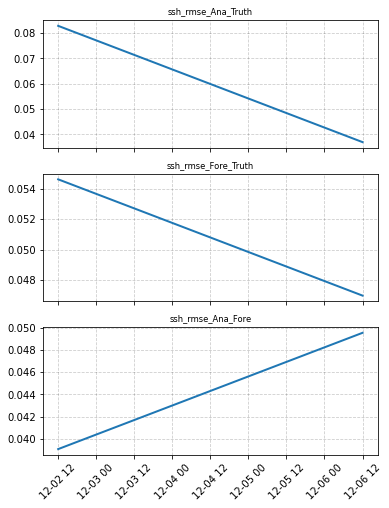

In [13]:
names = ('ssh_rmse_Ana_Truth','ssh_rmse_Fore_Truth','ssh_rmse_Ana_Fore')
xlabels = ('m','m','m')
rmse_metrics = xr.Dataset()

for name in names:
    rmse_metrics[name] = eval(name)

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)


plt_params = {'linewidth':2}


fig, axes = plt.subplots(3, figsize=(6, 8), sharex=True)
for ax, run in zip(axes, names):
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
    ax.set_title(run, fontsize='small',loc='center')
    ax.tick_params('x',labelrotation=45)


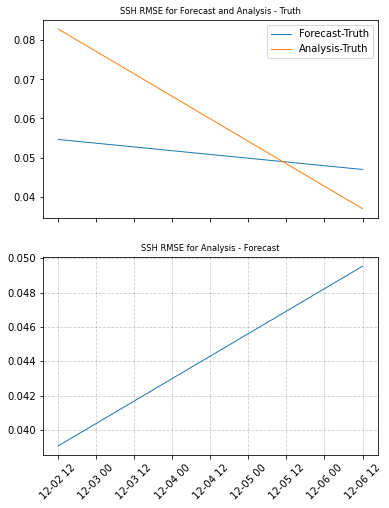

In [14]:

plt_params = {'linewidth':1}

fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax=axes[0]
plt_params = {'linewidth':1,'label':'Forecast-Truth'}
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Fore_Truth'],ax=ax, plt_kwargs=plt_params)
plt_params = {'linewidth':1,'label':'Analysis-Truth'}
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Ana_Truth'],ax=ax, plt_kwargs=plt_params)
ax.set_title('SSH RMSE for Forecast and Analysis - Truth', fontsize='small',loc='center')
ax.legend()
ax=axes[1]
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Ana_Fore'],ax=ax, plt_kwargs=plt_params)
ax.set_title('SSH RMSE for Analysis - Forecast', fontsize='small',loc='center')
ax.tick_params('x',labelrotation=45)


In [15]:
def plot_spatialMap(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)   


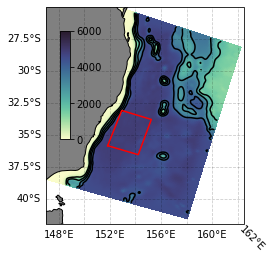

In [16]:
# xiRange = [114, 184]
# etaRange = [84, 149]

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)


fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMap(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()